In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
from tqdm import tqdm
import os
import copy

import pyPSFstack.pupils.sources as srcs
import pyPSFstack.pupils.windows as wdws
from pyPSFstack.pupils.aberrations import UnitaryAberrations, ScalarAberrations
from pyPSFstack.core import PSFStack
from pyPSFstack.functions import trim_stack
import pyPSFstack.diversities.pola_diversities as pdivs
from pyPSFstack.diversities.pupil_diversities import ZDiversity
from pyPSFstack.blurring.blurring import ExactBlurring

from torchPSFstack.psf_modules import torchPSFStack
from torchPSFstack.pupils.sources import torchDipoleInterfaceSource
from torchPSFstack.pupils.windows import torchSEO
from torchPSFstack.pupils.aberrations import torchUnitaryAberrations, torchScalarAberrations
from torchPSFstack.diversities.pupil_diversities import torchZDiversity
from torchPSFstack.diversities.pola_diversities import torchPDiversity_QWP, \
    torchPDiversity_LP, torchPDiversity_Compound
from torchPSFstack.blurring.blurring import torch2DBlurring, torchSABlurring
from torchPSFstack.cost_functions import loss_loglikelihood, loss_sumsquared
from torchPSFstack.functions import get_pupils_param_dict, get_normNbck, colorize


from functions4man import plot_zpstack, plot_zstack, plot_xyz, plot_jones, \
    get_xyzstack, find_pupil, cpx_corr
    
fig_folder='figures'

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['mathtext.fontset'] = 'cm'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams.update({"figure.facecolor" : "white"})
matplotlib.rcParams['font.family'] = 'Helvetica'

SMALL_SIZE = 9
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Numerical experiments for characterizing a birefringent window from a PSF stack

## 1. Parameter definition for the creation of simulated data

In [45]:
# Define number of points use for the computation 
N_pts = 128
# Experimental parameters
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.515
cam_pixel_size = 6500
radius = 10 # of the nanobead
wavelength = 605
dipole_orientation = [0,0,0] # this means incoherent
# Define positions of defocus
zi = -500; z_step = 100
z_list = np.arange(zi,-zi+z_step,z_step)
# Define rotation angles of polarization analyzer
angle_i = 0; angle_f = np.pi/2; angle_step = np.pi/8
angle_list=np.arange(angle_i,angle_f,angle_step)
blurring_slices = 21
alpha = 1.24211

We put all the parameters in a dictionary 

In [54]:
angle_list

array([0.        , 0.39269908, 0.78539816, 1.17809725])

In [46]:
params = {}
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = N_pts

params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = (radius + np.random.rand()*20 )/wavelength
params['source']['alpha'] = 0

params['defocus'] = {}
params['defocus']['nf'] = nf
params['defocus']['delta_z'] = (alpha*radius + (np.random.rand()-0.5)*40)/wavelength

params['qplate'] = {}
params['qplate']['q'] = 1/2

params['seo'] = {}
params['seo']['c'] = 1.25*np.pi

params['zdiversity'] = {}
params['zdiversity']['z_list'] = z_list / wavelength
params['zdiversity']['nf'] = nf

params['pdiversity'] = {}
params['pdiversity']['qwp_angles'] = angle_list
params['pdiversity']['lp_angles'] = [0,np.pi/2]

params['blurring'] = {}
params['blurring']['ni'] = ni
params['blurring']['nf'] = nf
params['blurring']['radius'] = radius/wavelength
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,blurring_slices+2)[1:-1] 

params_ret = copy.deepcopy(params)

params_ret['aberrations'] = {}
params_ret['aberrations']['jmax_list'] = [15]*4+[15]
params_ret['source']['delta'] = radius/wavelength
params_ret['source']['alpha'] = None
params_ret['defocus']['delta_z'] = 0

Instantiate all the class elements need to define a PSF stack

In [47]:
src = srcs.DipoleInterfaceSource(**params['pupil'],**params['source'])
defocus = wdws.Defocus(**params['pupil'],**params['defocus'])
qplate = wdws.Qplate(**params['pupil'],**params['qplate'])
seo = wdws.SEO(**params['pupil'],**params['seo'])
# Then the diversities
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])
qwp = pdivs.PDiversity_QWP(angle_list)
hwp = pdivs.PDiversity_HWP(angle_list)
wollaston = pdivs.PDiversity_LP([0, np.pi/2])
pdiv2 = pdivs.PDiversity_Compound([hwp, wollaston])
pdiv = pdivs.PDiversity_Compound([qwp, wollaston])
pol_seo = pdivs.PDiversity_Compound([pdivs.PDiversity_QWP([np.pi/4]), wollaston])

blurring = ExactBlurring(**params['blurring'],**params['pupil'])

In [5]:
def get_dNzf(psfs):
    delta = psfs.pupils[0].delta
    alpha = psfs.pupils[0].alpha
    delta_z = 0
    # if len(psfs.pupils)==3:
    delta_z = psfs.pupils[1].delta_z
    return delta, delta_z + alpha * delta

## 2. SEO

In [6]:
fig_sub_folder = 'seo_ret'

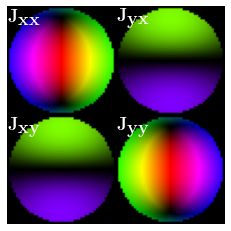

In [7]:
plot_jones(seo.get_pupil_array())
plt.savefig(os.path.join(fig_folder, fig_sub_folder,'jones_seo.pdf'), bbox_inches='tight')

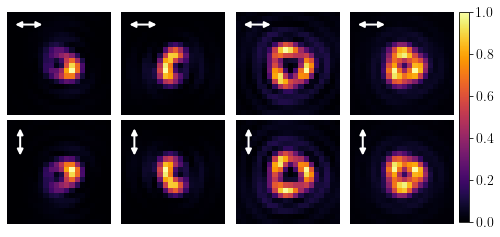

In [8]:
stack_xyz = get_xyzstack([src, seo], pol_seo)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder, fig_sub_folder,'seo_stackxyz.pdf'), bbox_inches='tight')

### 2.1 With polarization diversity

In [9]:
psfs = PSFStack([src, defocus, seo], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

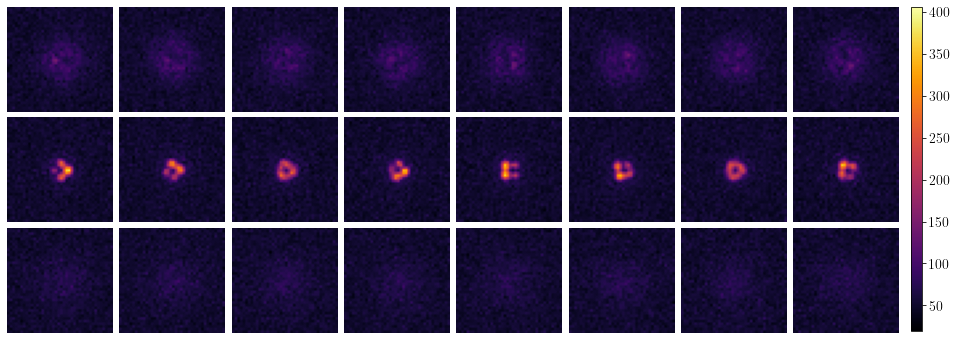

In [10]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zpstack(data_stack, N_p=8)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'stack.pdf'), bbox_inches='tight')

/opt/anaconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 200/200 [00:26<00:00,  7.55it/s]


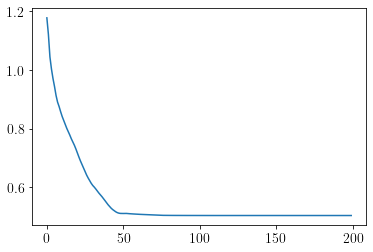

In [11]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, 
    loss_fn=loss_loglikelihood)
plt.plot(loss_evol)
# plt.gca().set_yscale('log')

0.05519073383079931 tensor(0.0190)
0.05465736306079399 tensor(0.0040)


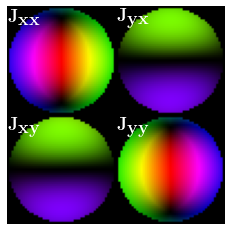

In [12]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_seo_retzp.pdf'), bbox_inches='tight')

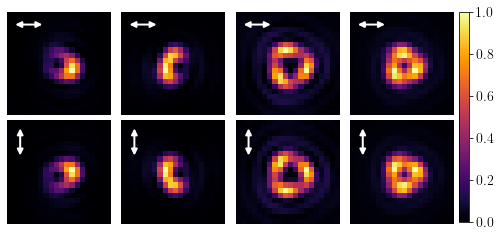

In [13]:
stack_xyz = get_xyzstack([src, abe], pol_seo)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'seo_stackxyz_retzp.pdf'), bbox_inches='tight')

### 2.2 Without polarization diversity

In [14]:
psfs = PSFStack([src, defocus, seo], zdiversity=zdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

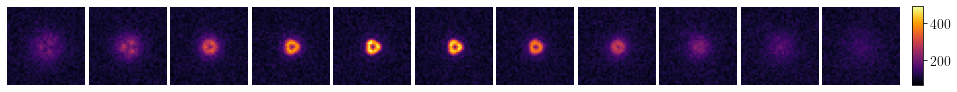

In [15]:
data_stack = psfs.model_experimental_stack(bckgd_photons=100,N_photons=20000,N_pts=40,noise=True)
plot_zstack(data_stack, N_z=11)

100%|██████████| 200/200 [00:17<00:00, 11.19it/s]


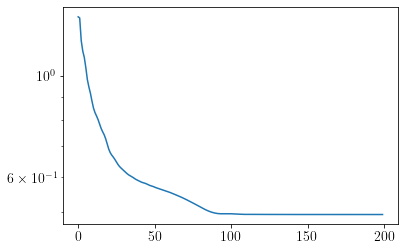

In [16]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood, pdiv=False)
plt.plot(loss_evol)
plt.gca().set_yscale('log')

0.05519073383079931 tensor(0.0190)
0.05465736306079399 tensor(0.0043)


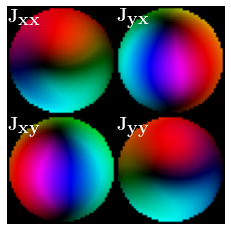

In [17]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_seo_retz.pdf'), bbox_inches='tight')

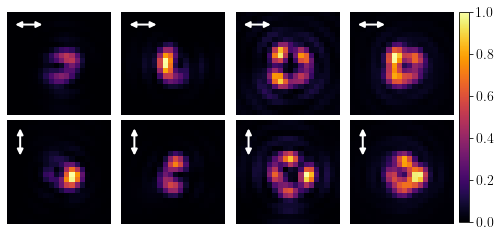

In [18]:
stack_xyz = get_xyzstack([src, abe], pol_seo)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'seo_stackxyz_retz.pdf'), bbox_inches='tight')

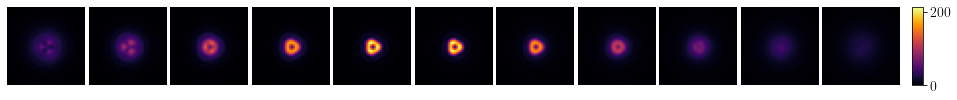

In [24]:
psfs_ret = PSFStack([src, defocus, abe], zdiversity=zdiv, blurring=blurring)
psfs_ret.compute_psf_stack(orientation=[0,0,0])
ret_stack = psfs_ret.model_experimental_stack(bckgd_photons=0,N_photons=10000,N_pts=40,noise=False)
plot_zstack(ret_stack, N_z=11)

## 3. Qplate

In [48]:
fig_sub_folder = 'qp_ret'

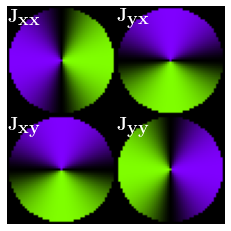

In [20]:
plot_jones(qplate.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_qp.pdf'), bbox_inches='tight')

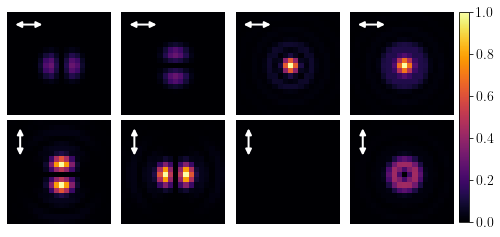

In [21]:
stack_xyz = get_xyzstack([src, qplate], wollaston)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'qp_stackxyz.pdf'), bbox_inches='tight')

### 3.1 With polarization diversity

In [49]:
psfs = PSFStack([src, defocus, qplate], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

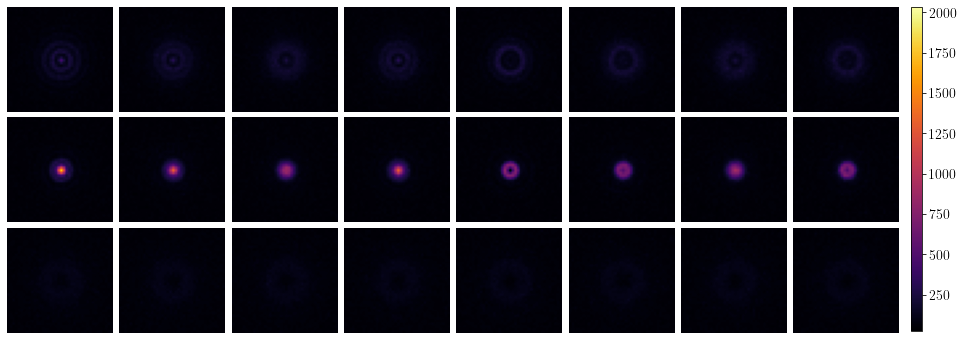

In [50]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=3*10000,N_pts=40,noise=True)
plot_zpstack(data_stack, N_p=8)

100%|██████████| 300/300 [00:47<00:00,  6.27it/s]


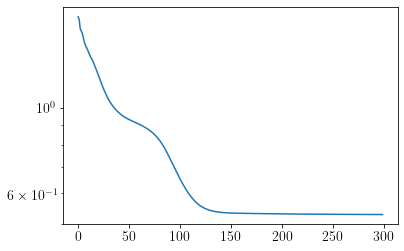

In [51]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=1e-2, n_epochs=300, 
    loss_fn=loss_loglikelihood)
plt.plot(loss_evol)
plt.gca().set_yscale('log')

0.04437571375531552 tensor(0.0190)
-0.007923674863604532 tensor(-0.0410)


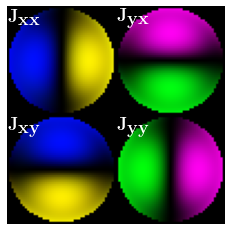

In [52]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta#ret_pupil_params['pupil0']['delta'] 
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_qp_retzp.pdf'), bbox_inches='tight')

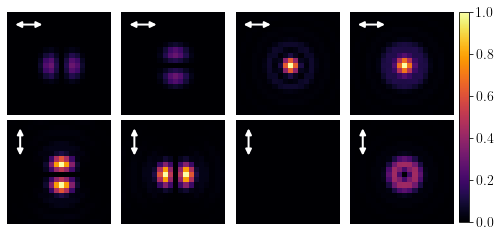

In [53]:
stack_xyz = get_xyzstack([src, abe], wollaston)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'qp_stackxyz_retzp.pdf'), bbox_inches='tight')

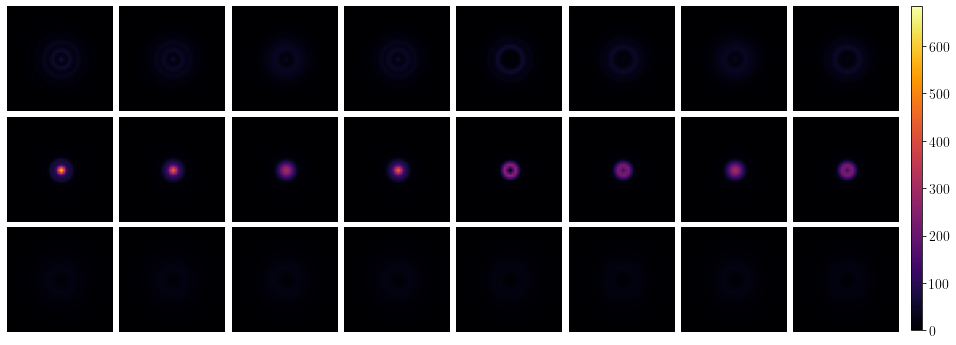

In [27]:
psfs_ret = PSFStack([src, defocus, abe], zdiversity=zdiv, pdiversity=pdiv)
psfs_ret.compute_psf_stack(orientation=[0,0,0])
ret_stack = psfs_ret.model_experimental_stack(bckgd_photons=0,N_photons=10000,N_pts=40,noise=False)
plot_zpstack(ret_stack, N_p=8)

### 3.2 Without polarization diversity

In [28]:
psfs = PSFStack([src, defocus, qplate], zdiversity=zdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

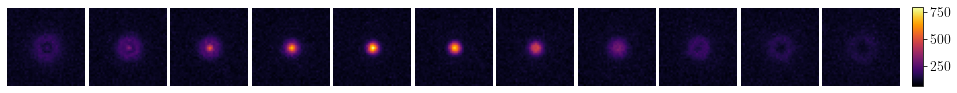

In [29]:
data_stack = psfs.model_experimental_stack(bckgd_photons=100,N_photons=20000,N_pts=40,noise=True)
plot_zstack(data_stack, N_z=11)

100%|██████████| 300/300 [00:28<00:00, 10.41it/s]


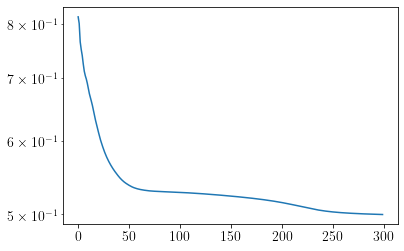

In [30]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=1e-2, n_epochs=300, loss_fn=loss_loglikelihood, pdiv=False)
plt.plot(loss_evol)
plt.gca().set_yscale('log')

0.05519073383079931 tensor(0.0190)
0.05465736306079399 tensor(0.0015)


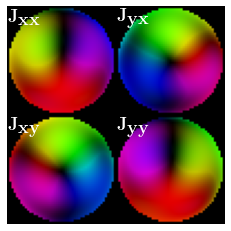

In [31]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_qp_retz.pdf'), bbox_inches='tight')

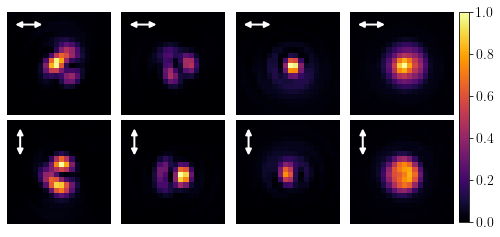

In [32]:
stack_xyz = get_xyzstack([src, abe], wollaston)
plot_xyz(stack_xyz)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'qp_stackxyz_retz.pdf'), bbox_inches='tight')

## 4. Blurring

In [33]:
fig_sub_folder = 'blurring_fig'
radius = 150
params['source']['alpha'] = 0
params['source']['delta'] = (radius + np.random.rand()*20)/wavelength
params['defocus']['delta_z'] = (alpha*radius + (np.random.rand()-0.5)*40)/wavelength
params['blurring']['radius'] = radius/wavelength
blurring_slices = 21
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,blurring_slices+2)[1:-1] 

params_ret['source']['delta'] = radius/wavelength

src = srcs.DipoleInterfaceSource(**params['pupil'],**params['source'])
defocus = wdws.Defocus(**params['pupil'],**params['defocus'])
blurring = ExactBlurring(**params['blurring'],**params['pupil'])

In [34]:
psfs = PSFStack([src, defocus, seo], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0], N_trim=40)

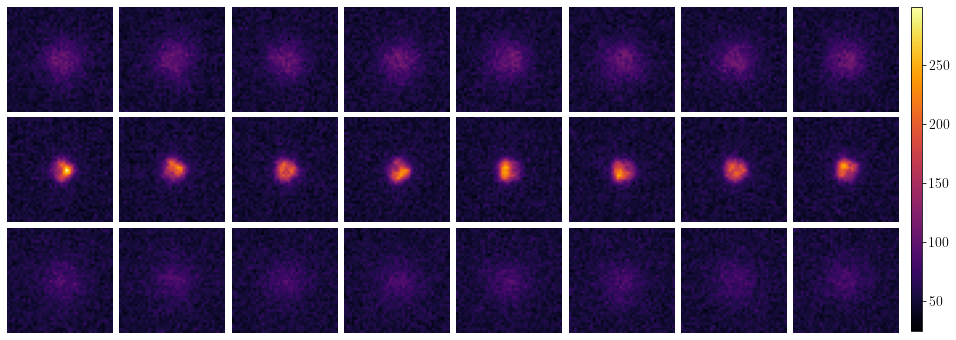

In [35]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,noise=True)
plot_zpstack(data_stack, N_p=8)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'blurred_stack.pdf'), bbox_inches='tight')

In [36]:
torch_blurr2d = torch2DBlurring(radius=radius/wavelength,**params['pupil'])
torch_blurrSA = torchSABlurring(radius=radius/wavelength,**params['pupil'])

100%|██████████| 200/200 [00:29<00:00,  6.81it/s]


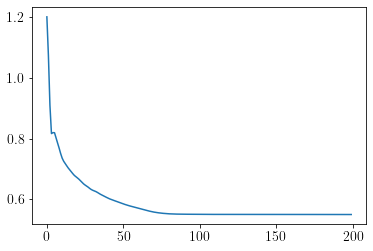

In [37]:
model_noblurr, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood)
plt.plot(loss_evol)

  0%|          | 0/200 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:156: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/Copy.cpp:244.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
100%|██████████| 200/200 [01:12<00:00,  2.76it/s]


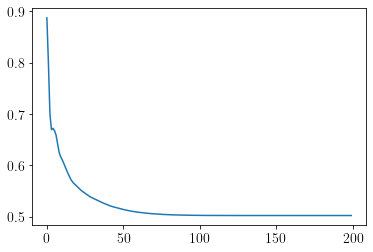

In [38]:
model_blurr2d, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood, 
    blurring=torch_blurr2d)
plt.plot(loss_evol)

100%|██████████| 200/200 [05:18<00:00,  1.59s/it]


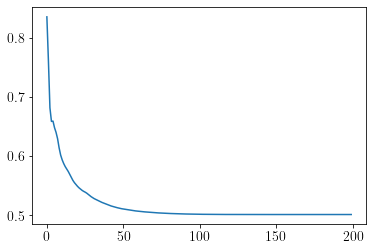

In [39]:
model_blurrSA, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, loss_fn=loss_loglikelihood, 
    blurring=torch_blurrSA)
plt.plot(loss_evol)

In [40]:
delta_gt, zf_gt = get_dNzf(psfs)

ret_pupil_params = get_pupils_param_dict(model_noblurr)
delta_noblurr = model_noblurr.pupils[0].delta
zf_noblurr = model_noblurr.pupils[0].alpha * delta_noblurr + ret_pupil_params['pupil1']['delta_z']
abe_noblurr = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])

ret_pupil_params = get_pupils_param_dict(model_blurr2d)
delta_blurr2d = model_blurr2d.pupils[0].delta
zf_blurr2d = model_blurr2d.pupils[0].alpha * delta_blurr2d + ret_pupil_params['pupil1']['delta_z']
abe_blurr2d = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])

ret_pupil_params = get_pupils_param_dict(model_blurrSA)
delta_blurrSA = model_blurrSA.pupils[0].delta
zf_blurrSA = model_blurrSA.pupils[0].alpha * delta_blurrSA + ret_pupil_params['pupil1']['delta_z']
abe_blurrSA = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])

In [41]:
print(delta_gt,delta_noblurr,delta_blurr2d,delta_blurrSA)
print(zf_gt,zf_noblurr,zf_blurr2d,zf_blurrSA)

0.3022933876387664 tensor(0.2857) tensor(0.2857) tensor(0.2857)
0.3714178919994323 tensor(0.2778) tensor(0.3622) tensor(0.3481)


In [42]:
corr = []
for bm, tag in [[abe_noblurr,'noblurr'], [abe_blurr2d,'2d'], [abe_blurrSA,'SA']]:
   corr += [cpx_corr(bm.get_pupil_array(), seo.get_pupil_array())]
np.abs(corr)

array([0.01678258, 0.97938821, 0.99701824])

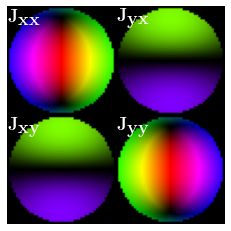

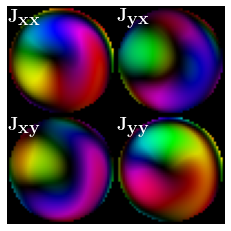

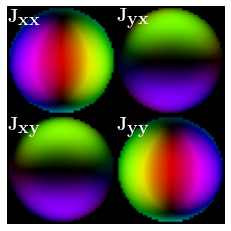

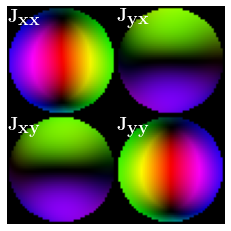

In [43]:
for bm, tag in [[seo,'gt'], [abe_noblurr,'noblurr'], [abe_blurr2d,'2d'], [abe_blurrSA,'SA']]:
    plot_jones(bm.get_pupil_array())
    plt.savefig(os.path.join(fig_folder,fig_sub_folder,'blurr_seo_'+tag+'.pdf'), bbox_inches='tight')

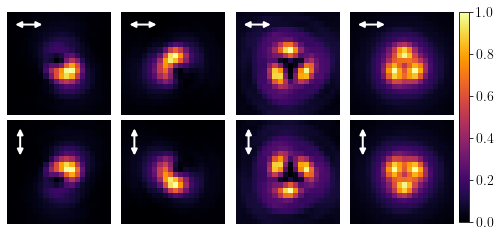

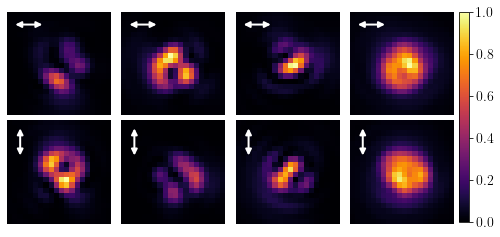

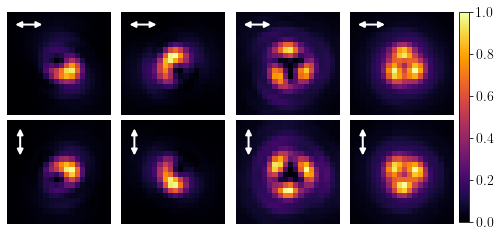

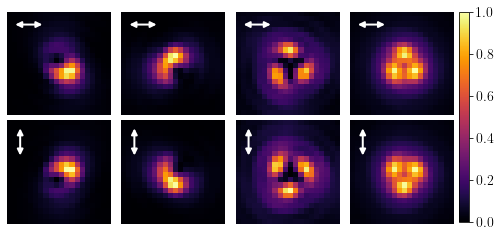

In [44]:
for bm, tag in [[seo,'gt'], [abe_noblurr,'noblurr'], [abe_blurr2d,'2d'], [abe_blurrSA,'SA']]:
    stack_xyz = get_xyzstack([src, bm], pol_seo)
    plot_xyz(stack_xyz)
    plt.savefig(os.path.join(fig_folder,fig_sub_folder,'blurr_seo_stackxyz_'+tag+'.pdf'), bbox_inches='tight')

## 5. Retrieval of scalar window

In [61]:
zi = -1000/5; z_step = 100
z_list = np.arange(zi,-zi+z_step,z_step)
params['zdiversity']['z_list'] = z_list / wavelength

params_ret['zdiversity']['z_list'] = z_list / wavelength
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])

In [62]:
c_W_tetra = np.array([0.595050119555554,0.489068290032588,0.452226752326030,
    0.260435586819384,0.047750334450534,-1.039441179976503,-0.175484816149914,
    0.833009549689635,0.154895303536154,-0.824227959830304,0.039942804577574,
    -4.443116227167999,0.254621433960892,3.604115918547898,
    -0.019994555526541])/(2*np.pi)
tetra = ScalarAberrations(c_A=[1], c_W=c_W_tetra[1:], **params['pupil'], index_convention='standard')

In [63]:
psfs = PSFStack([src, defocus, tetra], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

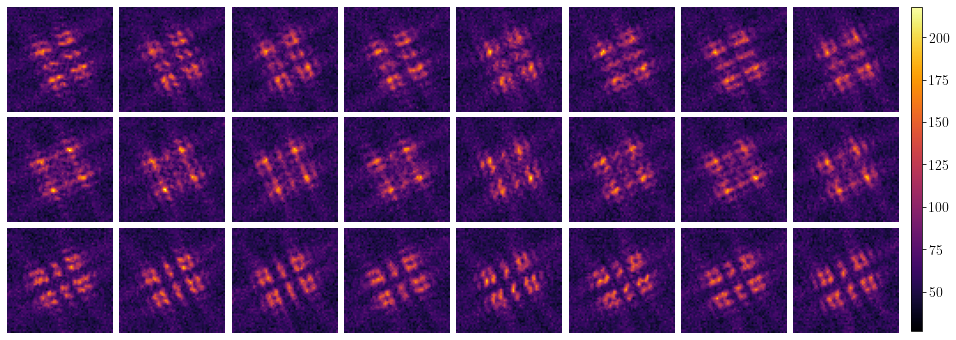

In [64]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=50000,N_pts=60,noise=True)
plot_zpstack(data_stack, N_p=8)

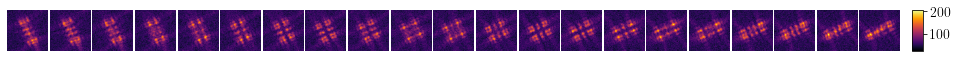

In [30]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=50000,N_pts=60,noise=True)
plot_zstack(data_stack, N_z=21)

100%|██████████| 400/400 [00:36<00:00, 11.05it/s]


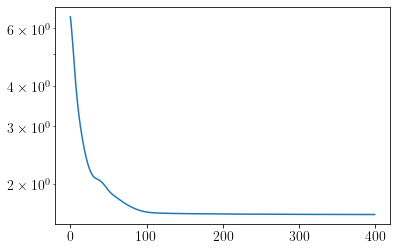

In [65]:
params_ret['aberrations']['jmax_list'] = [1,15]
model, loss_evol = find_pupil(data_stack, params_ret, lr=1e-2, n_epochs=400, 
    loss_fn=loss_loglikelihood, pdiv=True, abe='scalar')
plt.plot(loss_evol)
plt.gca().set_yscale('log')

In [66]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)

0.04641773499145821 tensor(0.0190)
0.0042485724204085855 tensor(-0.1377)


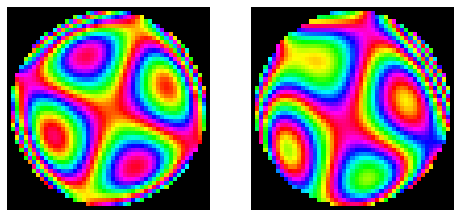

In [67]:
abe = ScalarAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(colorize(tetra.get_pupil_array()))
axs[1].imshow(colorize(abe.get_pupil_array()))
for ax in axs.ravel():
     ax.set_axis_off()

In [71]:
test = torch.nn.Parameter(torch.from_numpy(ret_pupil_params['pupil2']['c_W']).type(torch.float), requires_grad=True)

In [72]:
ret_pupil_params['pupil2']['c_W']

array([ 0.10723528,  0.3984647 , -0.13710268,  0.18277507, -0.19050352,
       -0.28466198,  0.1630807 , -0.12828608,  0.17860608,  0.61603975,
       -0.50914854,  0.45509538,  0.12343252,  0.0654395 ], dtype=float32)

## 6. Retrieval with defocus and saf

In [65]:
radius = 10
alpha = 1.34421# 1.24211
delta_shift = np.random.rand()*20 /wavelength
zf_shift = (np.random.rand()-0.5)*80/wavelength
print(delta_shift*wavelength, zf_shift*wavelength)
zi = -500; z_step = 100
z_list = np.arange(zi,-zi+z_step,z_step)

params['source']['delta'] = radius/wavelength + delta_shift
params['defocus']['delta_z'] = alpha*radius/wavelength + zf_shift

params['zdiversity']['z_list'] = z_list / wavelength


params_ret['aberrations']['jmax_list'] = [15]*4+[15]
params_ret['source']['delta'] = radius/wavelength
params_ret['source']['alpha'] = 1.34421
params_ret['defocus']['delta_z'] = 0
params_ret['zdiversity']['z_list'] = z_list / wavelength
params_ret['aberrations']['c_W'] = None
params_ret['aberrations']['c_q'] = None

src = srcs.DipoleInterfaceSource(**params['pupil'],**params['source'])
defocus = wdws.Defocus(**params['pupil'],**params['defocus'])
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])

10.584239487461101 26.13618872987469


### 6.1 No window

In [42]:
psfs = PSFStack([src, seo, defocus], zdiversity=zdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0],N_trim=40)

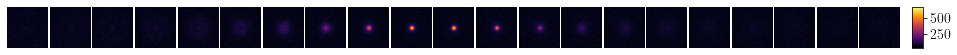

In [37]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zstack(data_stack, N_z=21)

100%|██████████| 300/300 [00:53<00:00,  5.60it/s]


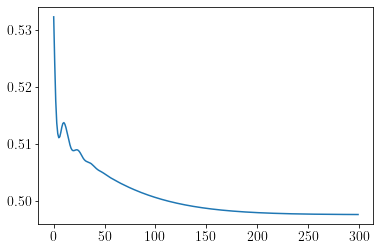

In [38]:
params_ret['aberrations']['jmax_list'] = [1,2]
model, loss_evol = find_pupil(data_stack, params_ret, lr=1e-2, n_epochs=300, 
loss_fn=loss_loglikelihood, pdiv=False, opt_def=True, opt_delta=True, abe='scalar')
plt.plot(loss_evol)

[16.99007272 10.         12.32392257]
[22.61989102 13.4421     15.90839843]


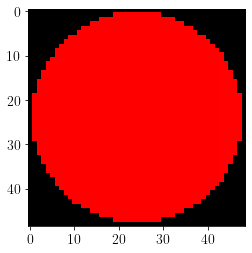

In [39]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_init = params_ret['source']['delta']
zf_init = delta_init *params_ret['source']['alpha']
delta_ret = ret_pupil_params['pupil0']['delta']
zf_ret = model.pupils[0].alpha * ret_pupil_params['pupil0']['delta'] + ret_pupil_params['pupil1']['delta_z']
print(np.array([delta_gt,delta_init,delta_ret])*wavelength)
print(np.array([zf_gt,zf_init,zf_ret])*wavelength)

abe = ScalarAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plt.imshow(colorize((abe.get_pupil_array())))

### 6.2 With SEO window

In [66]:
psfs = PSFStack([src, defocus, seo], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0],N_trim=40)

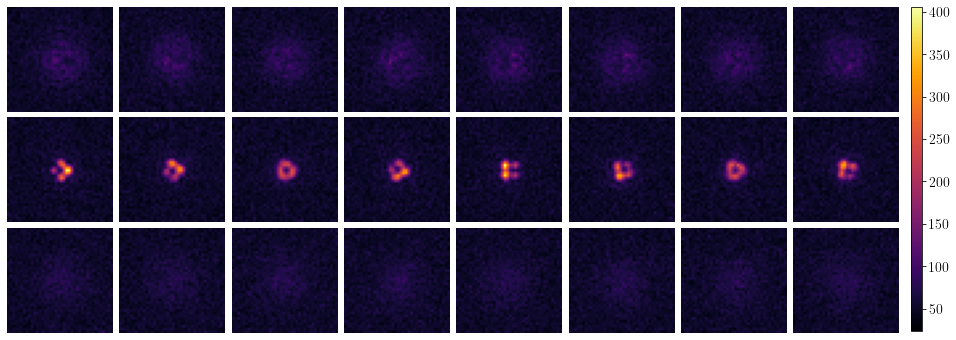

In [67]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zpstack(data_stack, N_p=8)

100%|██████████| 300/300 [00:49<00:00,  6.09it/s]


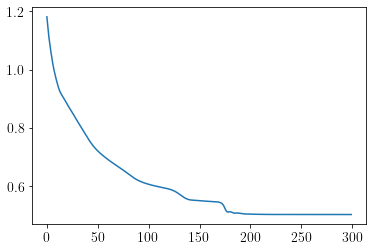

In [83]:
params_ret['aberrations']['c_W'] = None
params_ret['aberrations']['c_q'] = None
params_ret['aberrations']['jmax_list'] = [15]*5
model, loss_evol = find_pupil(data_stack, params_ret, lr=1e-2, n_epochs=300, 
loss_fn=loss_loglikelihood, pdiv=True, opt_def=True, opt_delta=False, abe='unitary')
plt.plot(loss_evol)

[20.58423949 10.         10.00000038]
[39.57828873 13.4421     24.79801203]


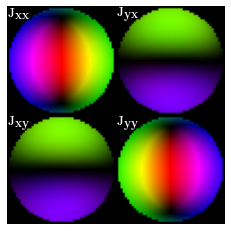

In [85]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_init = params_ret['source']['delta']
zf_init = delta_init *params_ret['source']['alpha']
delta_ret = model.pupils[0].delta.numpy() #ret_pupil_params['pupil0']['delta']
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(np.array([delta_gt,delta_init,delta_ret])*wavelength)
print(np.array([zf_gt,zf_init,zf_ret])*wavelength)

abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())

100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


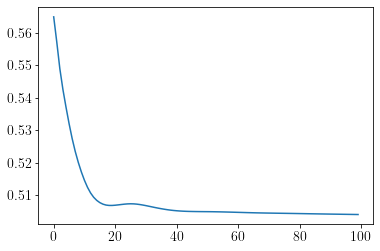

In [87]:
params_ret['aberrations']['c_W'] = ret_pupil_params['pupil2']['c_W']
params_ret['aberrations']['c_q'] = ret_pupil_params['pupil2']['c_q']
model, loss_evol = find_pupil(data_stack, params_ret, lr=0.3e-2, n_epochs=100, 
loss_fn=loss_loglikelihood, pdiv=True, opt_def=True, opt_delta=True, abe='unitary')
plt.plot(loss_evol)

[20.58423949 10.         36.2526929 ]
[39.57828873 13.4421     60.16250875]
0.999558696168133


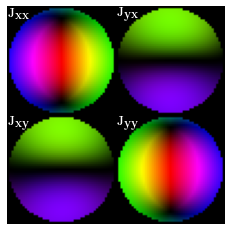

In [90]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_init = params_ret['source']['delta']
zf_init = delta_init *params_ret['source']['alpha']
delta_ret = ret_pupil_params['pupil0']['delta']
zf_ret = model.pupils[0].alpha * ret_pupil_params['pupil0']['delta'] + ret_pupil_params['pupil1']['delta_z']
print(np.array([delta_gt,delta_init,delta_ret])*wavelength)
print(np.array([zf_gt,zf_init,zf_ret])*wavelength)
print(np.abs(cpx_corr(abe.get_pupil_array(), seo.get_pupil_array())))
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())

### 6.3 With QP window

In [91]:
psfs = PSFStack([src, defocus, qplate], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0],N_trim=40)

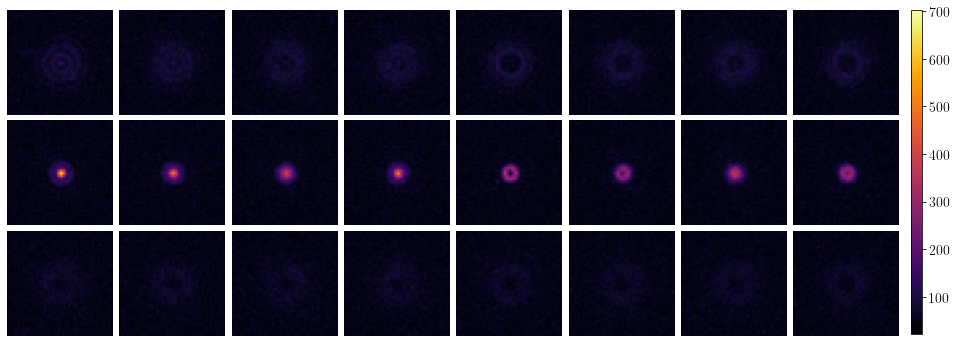

In [92]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zpstack(data_stack, N_p=8)

100%|██████████| 300/300 [00:39<00:00,  7.61it/s]


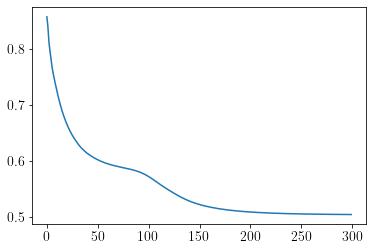

In [99]:
params_ret['aberrations']['c_W'] = None
params_ret['aberrations']['c_q'] = None
params_ret['aberrations']['jmax_list'] = [15]*5
model, loss_evol = find_pupil(data_stack, params_ret, lr=1e-2, n_epochs=300, 
loss_fn=loss_loglikelihood, pdiv=True, opt_def=True, opt_delta=False, abe='unitary')
plt.plot(loss_evol)

[20.58423949 10.         10.00000038]
[39.57828873 13.4421     27.04854563]
0.9888254900396785


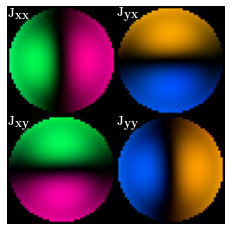

In [100]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_init = params_ret['source']['delta']
zf_init = delta_init *params_ret['source']['alpha']
delta_ret = model.pupils[0].delta.numpy() #ret_pupil_params['pupil0']['delta']
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(np.array([delta_gt,delta_init,delta_ret])*wavelength)
print(np.array([zf_gt,zf_init,zf_ret])*wavelength)

print(np.abs(cpx_corr(abe.get_pupil_array()[...,0,0], qplate.get_pupil_array()[...,0,0])))
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())

100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


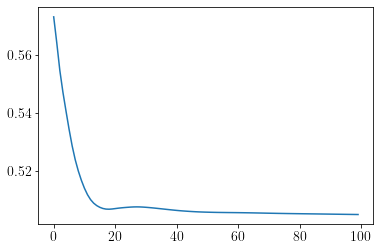

In [95]:
params_ret['aberrations']['c_W'] = ret_pupil_params['pupil2']['c_W']
params_ret['aberrations']['c_q'] = ret_pupil_params['pupil2']['c_q']
model, loss_evol = find_pupil(data_stack, params_ret, lr=0.3e-2, n_epochs=100, 
loss_fn=loss_loglikelihood, pdiv=True, opt_def=True, opt_delta=True, abe='unitary')
plt.plot(loss_evol)

[20.58423949 10.         38.03581428]
[39.57828873 13.4421     64.79682138]
0.9888254900396785


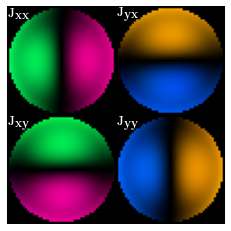

In [98]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_init = params_ret['source']['delta']
zf_init = delta_init *params_ret['source']['alpha']
delta_ret = ret_pupil_params['pupil0']['delta']
zf_ret = model.pupils[0].alpha * ret_pupil_params['pupil0']['delta'] + ret_pupil_params['pupil1']['delta_z']
print(np.array([delta_gt,delta_init,delta_ret])*wavelength)
print(np.array([zf_gt,zf_init,zf_ret])*wavelength)
print(np.abs(cpx_corr(abe.get_pupil_array()[...,0,0], qplate.get_pupil_array()[...,0,0])))
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())

# Extra stuff

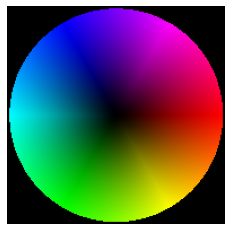

In [39]:
src2 = DipoleInterfaceSource(**params['pupil'],**params['source'])
src2.N_pts = 2**9
src2.step_f = src2.computation_size/src2.N_pts
r,phi =src2.polar_mesh()
ap = r*np.exp(1j*phi) *src2.get_aperture(dummy_ind=0)
# ap[src2.get_aperture(dummy_ind=0)==False] = np.nan 
plt.imshow(colorize(ap))
plt.gca().set_axis_off()
plt.savefig(os.path.join(fig_folder,'ampNphase_cb.pdf'), bbox_inches='tight')

In [ ]:
import scipy.io as sio
import sys
import os

In [ ]:
mat_data = sio.loadmat(os.path.join('data','Rodrigo_14Jul2021_TIRF_Run1.mat'))

In [ ]:
zdiv_mid_ind = 6
fig, axs = plt.subplots(3,3,figsize=(8,8))
for ind in range(3):
    axs[0,ind].imshow(mat_data['beads_rodrigo'][0,...,0,ind])
    axs[1,ind].imshow(mat_data['beads_rodrigo'][0,...,zdiv_mid_ind,ind])
    axs[2,ind].imshow(mat_data['beads_rodrigo'][0,...,-1,ind])
for ax in axs.ravel():
    ax.set_axis_off()

In [ ]:
exp_stack = 0.24*(mat_data['beads_rodrigo'][0]-100)

In [ ]:
get_normNbck(exp_stack)